In [1]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
import seaborn as sns
import os 
import pandas_ta as ta 
import time
from datetime import datetime, timedelta
import math
from tqdm.auto import tqdm 
import matplotlib.pyplot as plt 
from transformers import * 
import torch 
from torch import Tensor 
from torch.utils.data import * 
import torch.nn as nn 
import torch.nn.functional as F 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score
from imblearn.under_sampling import RandomUnderSampler
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from scipy.spatial.distance import cdist 
import random 
import warnings 
warnings.filterwarnings("ignore") 
import pickle
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier  
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import DecisionBoundaryDisplay
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler 

/opt/conda/lib/python3.8/site-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [2]:
def seed_everything(seed): 
    random.seed(seed) 
    os.environ["PYTHONHASHSEED"] = str(seed) 
    np.random.seed(seed) 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed(seed) 
    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = True 

seed_everything(42) # fix seed to 42 

# Define Transformer Architecture

In [3]:
# define model
class PositionalEncoding(nn.Module): 
    def __init__(self, d_model, dropout=0.1, max_len=5000): 
        super(PositionalEncoding, self).__init__() 
        self.dropout = nn.Dropout(p=dropout) 
        pe = torch.zeros(max_len, d_model) 
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) 
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) 
        pe[:, 0::2] = torch.sin(position * div_term) 
        pe[:, 1::2] = torch.cos(position * div_term) 
        pe = pe.unsqueeze(0).transpose(0,1) 
        self.register_buffer("pe", pe) 
    def forward(self, x): 
        x = x + self.pe[:x.size(0), :] 
        return self.dropout(x) 

class MultiSampleDropout(nn.Module): 
    def __init__(self, max_dropout_rate, num_samples, classifier): 
        super(MultiSampleDropout, self).__init__() 
        self.dropout = nn.Dropout 
        self.classifier = classifier 
        self.max_dropout_rate = max_dropout_rate 
        self.num_samples = num_samples 
    def forward(self, out): 
        return torch.mean(torch.stack([self.classifier(self.dropout(p=rate)(out)) for _, rate in enumerate(np.linspace(0, self.max_dropout_rate, self.num_samples))], dim=0), dim=0)

class AttentivePooling(torch.nn.Module): 
    def __init__(self, input_dim): 
        super(AttentivePooling, self).__init__() 
        self.W = nn.Linear(input_dim, 1) 
    def forward(self, x): 
        softmax = F.softmax 
        att_w = softmax(self.W(x).squeeze(-1)).unsqueeze(-1) 
        x = torch.sum(x * att_w, dim=1) 
        return x 

class Encoder(nn.Module): 
    def __init__(self, 
                 chart_features, 
                 sequence_length, 
                 d_model=128, 
                 num_classes=3, 
                 n_heads=8, 
                 num_encoders=6,
                 dropout_r=0.2,
                 dropout_num_samples=4): 
        super(Encoder, self).__init__() 
        self.chart_features = chart_features 
        self.sequence_length = sequence_length  
        self.d_model = d_model 
        self.num_classes = num_classes  
        self.n_heads = n_heads 
        self.num_encoders = num_encoders 
        self.batchnorm = nn.BatchNorm1d(self.sequence_length)
        self.dropout_r = dropout_r 
        self.dropout_num_samples = dropout_num_samples
        self.chart_embedder = nn.Sequential(
            nn.Linear(self.chart_features, d_model//2), 
            nn.ReLU(), 
            nn.Linear(d_model//2, d_model) 
        ) 
        self.pos_encoder = PositionalEncoding(d_model=self.d_model) 
        self.encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.n_heads, batch_first=True) 
        self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=self.num_encoders) 
        self.attentive_pooling = AttentivePooling(input_dim=self.d_model)   
        self.fc = nn.Linear(self.d_model, self.num_classes) 
        self.multi_dropout = MultiSampleDropout(self.dropout_r, self.dropout_num_samples, self.fc) 
    def forward(self, x):
        x = self.batchnorm(x) 
        x = self.chart_embedder(x)
        x = self.pos_encoder(x) 
        x = self.transformer_encoder(x) 
        x = self.attentive_pooling(x) 
        x = self.multi_dropout(x)  
        return x 


# Preprocess Data: Without Pattern FE

In [4]:
with open("BTC_USDT-4h-12.json") as f: 
    d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
    binance = ccxt.binance() 
    dates = df["timestamp"].values 
    timestamp = [] 
    for i in range(len(dates)):
        date_string = binance.iso8601(int(dates[i])) 
        date_string = date_string[:10] + " " + date_string[11:-5] 
        timestamp.append(date_string) 
    df["datetime"] = timestamp
    df = df.drop(columns={"timestamp"}) 
    return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

  0%|          | 0/11852 [00:00<?, ?it/s]

In [5]:
def preprocess_seq_data(chart_df, threshold=0.0075): 
    targets = [] 
    openv = chart_df["open"].values 
    close = chart_df["close"].values 
    high = chart_df["high"].values 
    low = chart_df["low"].values  
    volume = chart_df["volume"].values 
    
    for i in range(close.shape[0]-1):
        high_vol = (high[i+1] - close[i]) / close[i] 
        low_vol = (low[i+1] - close[i]) / close[i] 
        if high_vol >= threshold: 
            targets.append(0) 
        elif low_vol <= -threshold:
            targets.append(1) 
        else:
            targets.append(2) 
        
    targets.append(None) 
    chart_df["Targets"] = targets 
    
    chart_df.set_index(pd.DatetimeIndex(chart_df["datetime"]), inplace=True)
    chart_df["bop"] = chart_df.ta.bop(lookahead=False) 
    chart_df["ebsw"] = chart_df.ta.ebsw(lookahead=False) 
    chart_df["cmf"] = chart_df.ta.cmf(lookahead=False) 
    chart_df["rsi/100"] = chart_df.ta.rsi(lookahead=False) / 100
    chart_df["high/low"] = chart_df["high"] / chart_df["low"] 
    chart_df["high/open"] = chart_df["high"] / chart_df["open"] 
    chart_df["low/open"] = chart_df["low"] / chart_df["open"] 
    chart_df["close/open"] = chart_df["close"] / chart_df["open"] 
    chart_df["high/close"] = chart_df["high"] / chart_df["close"] 
    chart_df["low/close"] = chart_df["low"] / chart_df["close"]     
    for l in tqdm(range(1, 12), position=0, leave=True): 
        for col in ["open", "high", "low", "close", "volume"]:
            val = chart_df[col].values 
            val_ret = [None for _ in range(l)]
            for i in range(l, len(val)):
                if val[i-l] == 0: 
                    ret = 1 
                else:
                    ret = val[i] / val[i-l]  
                val_ret.append(ret) 
            chart_df["{}_change_{}".format(col, l)] = val_ret 

    chart_df.dropna(inplace=True) 
    chart_df.drop(columns={"open", "high", "low", "close", "volume"}, inplace=True) 
    return chart_df

  0%|          | 0/11 [00:00<?, ?it/s]

<AxesSubplot:xlabel='Targets', ylabel='count'>

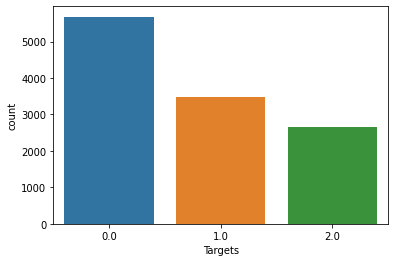

In [6]:
chart_df = preprocess_seq_data(chart_df) 

sns.countplot(chart_df, x="Targets")

In [7]:
train_columns = []
for col in chart_df.columns:
    if col not in ["Targets", "datetime", "years"]:
        train_columns.append(col)  

X = chart_df[train_columns] 
Y = chart_df["Targets"] 

train_size = int(chart_df.shape[0] * 0.8) 
val_size = int(chart_df.shape[0] * 0.1) 

X_train = X.iloc[:train_size] 
Y_train = Y.iloc[:train_size] 

X_val = X.iloc[train_size:train_size+val_size] 
Y_val = Y.iloc[train_size:train_size+val_size] 

X_test = X.iloc[train_size+val_size:] 
Y_test = Y.iloc[train_size+val_size:] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape 

((9449, 68), (9449,), (1181, 68), (1181,), (1182, 68), (1182,))

In [8]:
lookback = 6 

full_val = pd.concat([X_val, Y_val], axis=1) 

full_val.shape 

(1181, 69)

In [9]:
test = pd.concat([X_test, Y_test], axis=1) 

test.shape

(1182, 69)

In [10]:
full_df = pd.concat([full_val, test], axis=0) 

full_df.shape

(2363, 69)

In [11]:
train_columns = [] 
for col in full_df.columns: 
    if col not in ["Targets", "hours", "days", "months"]: 
        train_columns.append(col) 

In [12]:
X = [] 
Y = [] 

for i in tqdm(range(lookback, full_df.shape[0]), position=0, leave=True):
    X.append(full_df[train_columns].iloc[i-lookback:i].values) 
    Y.append(full_df["Targets"].iloc[i-1]) 
    

  0%|          | 0/2357 [00:00<?, ?it/s]

In [13]:
X = torch.tensor(X).float()  
Y = torch.tensor(Y, dtype=int) 
X.shape, Y.shape

(torch.Size([2357, 6, 65]), torch.Size([2357]))

In [14]:
train_size = int(0.8 * X.shape[0]) 
val_size = int(0.1 * X.shape[0]) 

X_train = X[:train_size] 
Y_train = Y[:train_size] 

X_val = X[train_size:train_size+val_size] 
Y_val = Y[train_size:train_size+val_size] 

X_test = X[train_size+val_size:] 
Y_test = Y[train_size+val_size:] 

X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

(torch.Size([1885, 6, 65]),
 torch.Size([1885]),
 torch.Size([235, 6, 65]),
 torch.Size([235]),
 torch.Size([237, 6, 65]),
 torch.Size([237]))

In [15]:
batch_size = 128
train_data = TensorDataset(X_train, Y_train)
train_sampler = RandomSampler(train_data) 
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) 

val_data = TensorDataset(X_val, Y_val) 
val_sampler = SequentialSampler(val_data) 
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size) 

test_data = TensorDataset(X_test, Y_test) 
test_sampler = SequentialSampler(test_data) 
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)  

In [16]:
train_losses, val_losses = [], [] 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = Encoder(chart_features=X_train.shape[2], 
                sequence_length=X_train.shape[1])
model.to(device) 
optimizer = AdamW(model.parameters(), lr=1e-4) 
epochs = 50
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.05*total_steps), num_training_steps=total_steps)
class_weights = compute_class_weight(class_weight="balanced", classes=torch.unique(Y_train).numpy(), y=Y_train.numpy())
class_weights = torch.tensor(class_weights).float().to(device) 
loss_func = nn.CrossEntropyLoss(weight = class_weights)

best_val_loss = 99999999999
best_epoch = -1 

model.zero_grad() 
for epoch_i in tqdm(range(epochs), desc="Epochs", position=0, leave=True, total=epochs): 
    train_loss = 0 
    model.train() 
    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch) 
        b_seqs, b_labels = batch 
        outputs = model(b_seqs) 
        loss = loss_func(outputs, b_labels) 
        train_loss += loss.item() 
        loss.backward() 
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step() 
        scheduler.step() 
        model.zero_grad() 
    avg_train_loss = train_loss / len(train_dataloader) 
    train_losses.append(avg_train_loss) 
    val_loss = 0 
    for step, batch in enumerate(val_dataloader):
        batch = tuple(t.to(device) for t in batch) 
        b_seqs, b_labels = batch 
        outputs = model(b_seqs) 
        loss = loss_func(outputs, b_labels) 
        val_loss += loss.item() 
    avg_val_loss = val_loss / len(val_dataloader) 
    val_losses.append(avg_val_loss)  
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_epoch = epoch_i 
        torch.save(model.state_dict(), "TFEncoder_noFE.pt")

print("done training!") 

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


In [17]:
best_val_loss, best_epoch  

(1.011201411485672, 0)

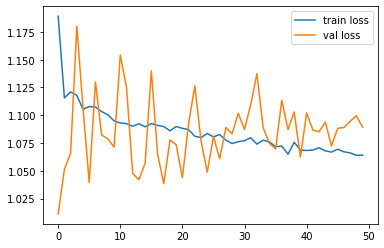

In [18]:
plt.plot(train_losses, label="train loss") 
plt.plot(val_losses, label="val loss") 
plt.legend()

In [19]:
predictions = [] 
ground_truths = [] 

best_model = Encoder(chart_features=X_train.shape[2], sequence_length=X_train.shape[1])
checkpoint = torch.load("TFEncoder_noFE.pt")
best_model.load_state_dict(checkpoint) 
best_model.to(device)
best_model.eval() 

for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)): 
    batch = tuple(t.to(device) for t in batch) 
    b_seqs, b_labels = batch 
    with torch.no_grad():
        outputs = best_model(b_seqs) 
        probs = nn.Softmax()(outputs) 
        classes = torch.argmax(probs, dim=1) 
    for i in range(classes.shape[0]): 
        predictions.append(classes[i].item()) 
        ground_truths.append(b_labels[i].item()) 

  0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
cnt = 0 
for i in range(len(predictions)):
    if predictions[i] == ground_truths[i]:
        cnt += 1 
        
accuracy = cnt / len(predictions) * 100.0 
f1 = f1_score(ground_truths, predictions, average="weighted") 

print(f"accuracy : {accuracy}% | Weighted F1 : {f1}") 

accuracy : 68.35443037974683% | Weighted F1 : 0.635256098091452


# With similar patterns used: scores softmax normalized

In [21]:
with open("xgb_chart_similar_dates_ED.pkl", "rb") as f: 
    similar_dict = pickle.load(f) 

In [22]:
comp_columns = train_columns[3:] 

date_chart_info = {} # date, index 

all_dates = chart_df.index 

for i in tqdm(range(len(all_dates)), position=0, leave=True): 
    date_chart_info[all_dates[i]] = i

  0%|          | 0/11812 [00:00<?, ?it/s]

In [35]:
accuracies, f1_scores = [], []
lookback = 6 

for topk in [5, 10, 15, 20, 25, 30]: 
    long_cnt, short_cnt, hold_cnt = [], [], []
    for key, value in tqdm(similar_dict.items(), position=0, leave=True):
        query_idx = date_chart_info[key]
        query_target = chart_df["Targets"].iloc[query_idx] 
        cnt_map = {0:0, 1:0, 2:0} 
        for i in range(len(value[:topk])):
            candidate_idx = date_chart_info[value[i][0]] 
            candidate_target = chart_df["Targets"].iloc[candidate_idx] 
            cnt_map[candidate_target] += 1 
        softmaxed = nn.Softmax()(torch.tensor([cnt_map[0], cnt_map[1], cnt_map[2]]).float()) 
        long_cnt.append(softmaxed[0].item()) 
        short_cnt.append(softmaxed[1].item()) 
        hold_cnt.append(softmaxed[2].item()) 
    full_df["long_vote"] = long_cnt 
    full_df["short_vote"] = short_cnt 
    full_df["hold_vote"] = hold_cnt
    
    train_columns = [] 
    for col in full_df.columns: 
        if col not in ["Targets", "hours", "days", "months"]: 
            train_columns.append(col) 
            
    X, Y = [], [] 
    for i in tqdm(range(lookback, full_df.shape[0]), position=0, leave=True): 
        X.append(full_df[train_columns].iloc[i-lookback:i].values)  
        Y.append(full_df["Targets"].iloc[i-1]) 
    X = torch.tensor(X).float() 
    Y = torch.tensor(Y, dtype=int)  
    
    train_size = int(0.8 * X.shape[0]) 
    val_size = int(0.1 * X.shape[0]) 

    X_train = X[:train_size] 
    Y_train = Y[:train_size] 

    X_val = X[train_size:train_size+val_size] 
    Y_val = Y[train_size:train_size+val_size] 

    X_test = X[train_size+val_size:] 
    Y_test = Y[train_size+val_size:] 

    batch_size = 128
    train_data = TensorDataset(X_train, Y_train)
    train_sampler = RandomSampler(train_data) 
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size) 

    val_data = TensorDataset(X_val, Y_val) 
    val_sampler = SequentialSampler(val_data) 
    val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size) 

    test_data = TensorDataset(X_test, Y_test) 
    test_sampler = SequentialSampler(test_data) 
    test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)  
    
    train_losses, val_losses = [], [] 

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
    model = Encoder(chart_features=X_train.shape[2], 
                    sequence_length=X_train.shape[1])
    model.to(device) 
    optimizer = AdamW(model.parameters(), lr=1e-4) 
    epochs = 50
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(0.05*total_steps), num_training_steps=total_steps)
    class_weights = compute_class_weight(class_weight="balanced", classes=torch.unique(Y_train).numpy(), y=Y_train.numpy())
    class_weights = torch.tensor(class_weights).float().to(device) 
    loss_func = nn.CrossEntropyLoss(weight = class_weights)

    best_val_loss = 99999999999
    best_epoch = -1 

    model.zero_grad() 
    for epoch_i in tqdm(range(epochs), desc="Epochs", position=0, leave=True, total=epochs): 
        train_loss = 0 
        model.train() 
        for step, batch in enumerate(train_dataloader):
            batch = tuple(t.to(device) for t in batch) 
            b_seqs, b_labels = batch 
            outputs = model(b_seqs) 
            loss = loss_func(outputs, b_labels) 
            train_loss += loss.item() 
            loss.backward() 
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step() 
            scheduler.step() 
            model.zero_grad() 
        avg_train_loss = train_loss / len(train_dataloader) 
        train_losses.append(avg_train_loss) 
        val_loss = 0 
        for step, batch in enumerate(val_dataloader):
            batch = tuple(t.to(device) for t in batch) 
            b_seqs, b_labels = batch 
            outputs = model(b_seqs) 
            loss = loss_func(outputs, b_labels) 
            val_loss += loss.item() 
        avg_val_loss = val_loss / len(val_dataloader) 
        val_losses.append(avg_val_loss)  
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_epoch = epoch_i 
            torch.save(model.state_dict(), f"ED_top{topk}_TFEncoder_FE.pt")

    print("done training!") 
    
    predictions = [] 
    ground_truths = [] 

    best_model = Encoder(chart_features=X_train.shape[2], sequence_length=X_train.shape[1])
    checkpoint = torch.load(f"ED_top{topk}_TFEncoder_FE.pt")
    best_model.load_state_dict(checkpoint) 
    best_model.to(device)
    best_model.eval() 

    for step, batch in tqdm(enumerate(test_dataloader), total=len(test_dataloader)): 
        batch = tuple(t.to(device) for t in batch) 
        b_seqs, b_labels = batch 
        with torch.no_grad():
            outputs = best_model(b_seqs) 
            probs = nn.Softmax()(outputs) 
            classes = torch.argmax(probs, dim=1) 
        for i in range(classes.shape[0]): 
            predictions.append(classes[i].item()) 
            ground_truths.append(b_labels[i].item())  
    
    cnt = 0 
    for i in range(len(predictions)):
        if predictions[i] == ground_truths[i]:
            cnt += 1 

    accuracy = cnt / len(predictions) * 100.0 
    f1 = f1_score(ground_truths, predictions, average="weighted") 

    accuracies.append(accuracy) 
    f1_scores.append(f1) 
    
    print(f"using top {topk} similar data") 
    print(f"accuracy : {accuracy}% | Weighted F1 : {f1}") 

  0%|          | 0/2363 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


  0%|          | 0/2 [00:00<?, ?it/s]

using top 5 similar data
accuracy : 73.41772151898735% | Weighted F1 : 0.6395022944962888


  0%|          | 0/2363 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


  0%|          | 0/2 [00:00<?, ?it/s]

using top 10 similar data
accuracy : 74.68354430379746% | Weighted F1 : 0.6588110184899318


  0%|          | 0/2363 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


  0%|          | 0/2 [00:00<?, ?it/s]

using top 15 similar data
accuracy : 61.18143459915611% | Weighted F1 : 0.6325331231271232


  0%|          | 0/2363 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


  0%|          | 0/2 [00:00<?, ?it/s]

using top 20 similar data
accuracy : 65.82278481012658% | Weighted F1 : 0.6362973764828185


  0%|          | 0/2363 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


  0%|          | 0/2 [00:00<?, ?it/s]

using top 25 similar data
accuracy : 70.46413502109705% | Weighted F1 : 0.6715006891613545


  0%|          | 0/2363 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]

done training!


  0%|          | 0/2 [00:00<?, ?it/s]

using top 30 similar data
accuracy : 71.72995780590718% | Weighted F1 : 0.6622405932705686


In [36]:
mean_accuracy = np.mean(accuracies) 
mean_f1 = np.mean(f1_scores) 

print(f"mean accuracy: {mean_accuracy}% | mean weighted F1: {mean_f1}") 

mean accuracy: 69.54992967651195% | mean weighted F1: 0.6501475158380142
